# YOLOV3

## Installs 

In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (955 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155222 files and directories cur

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
!pip install keras==2.2.4 

  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 4.3 MB/s 
     |████████████████████████████████| 15.7 MB 55.0 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.4 which is incompatible.
yellowbrick 1.3.post1 requires numpy<1.20,

## *** RESTART RUNTIME ***

Restart Runtime and start from this point. This will set the correct versions of modules

### Imports

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import h5py
print("h5py Version: ", h5py.__version__) # needs to be  2.10.0
assert h5py.__version__ == "2.10.0"

h5py Version:  2.10.0


In [ ]:
import keras
print("Keras Version: ", keras.__version__) # needs to be 2.2.4
assert keras.__version__ == "2.2.4"

Using TensorFlow backend.


Keras Version:  2.2.4


### Note: If module versions are not correct, rerun the pip install block that is needed and restart runtime

In [ ]:
import sys
import shutil
import os
import configparser
import io
from collections import defaultdict

In [ ]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.layers import (Conv2D, Input, ZeroPadding2D, Add,
                          UpSampling2D, MaxPooling2D, Concatenate)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-12-05 14:58:11--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.3MB/s    in 11s     

2021-12-05 14:58:23 (21.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
#!git clone https://github.com/roboflow-ai/keras-yolo3.git

In [ ]:
!rm -rf yolov3
!git clone https://github.com/awells-uva/yolov3.git

Cloning into 'yolov3'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 67 (delta 33), reused 49 (delta 18), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
%ls

sample_data/  yolov3/  yolov3.weights


### Functions

In [ ]:
"""
Reads Darknet config and weights and creates Keras model with TF backend.

"""
def unique_config_sections(config_file):
    """Convert all config sections to have unique names.

    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream

def build_Keras_model(config_path, weights_path, output_path , weights_only, plot_model=False):
    config_path = config_path
    weights_path = weights_path
    assert config_path.endswith('.cfg'), '{} is not a .cfg file'.format(
        config_path)
    assert weights_path.endswith(
        '.weights'), '{} is not a .weights file'.format(weights_path)

    output_path = output_path
    assert output_path.endswith(
        '.h5'), 'output path {} is not a .h5 file'.format(output_path)
    output_root = os.path.splitext(output_path)[0]

    # Load weights and config.
    print('Loading weights.')
    weights_file = open(weights_path, 'rb')
    major, minor, revision = np.ndarray(
        shape=(3, ), dtype='int32', buffer=weights_file.read(12))
    if (major*10+minor)>=2 and major<1000 and minor<1000:
        seen = np.ndarray(shape=(1,), dtype='int64', buffer=weights_file.read(8))
    else:
        seen = np.ndarray(shape=(1,), dtype='int32', buffer=weights_file.read(4))
    print('Weights Header: ', major, minor, revision, seen)

    print('Parsing Darknet config.')
    unique_config_file = unique_config_sections(config_path)
    cfg_parser = configparser.ConfigParser()
    cfg_parser.read_file(unique_config_file)

    print('Creating Keras model.')
    input_layer = Input(shape=(None, None, 3))
    prev_layer = input_layer
    all_layers = []

    weight_decay = float(cfg_parser['net_0']['decay']
                         ) if 'net_0' in cfg_parser.sections() else 5e-4
    count = 0
    out_index = []
    for section in cfg_parser.sections():
        print('Parsing section {}'.format(section))
        if section.startswith('convolutional'):
            filters = int(cfg_parser[section]['filters'])
            size = int(cfg_parser[section]['size'])
            stride = int(cfg_parser[section]['stride'])
            pad = int(cfg_parser[section]['pad'])
            activation = cfg_parser[section]['activation']
            batch_normalize = 'batch_normalize' in cfg_parser[section]

            padding = 'same' if pad == 1 and stride == 1 else 'valid'

            # Setting weights.
            # Darknet serializes convolutional weights as:
            # [bias/beta, [gamma, mean, variance], conv_weights]
            prev_layer_shape = K.int_shape(prev_layer)

            weights_shape = (size, size, prev_layer_shape[-1], filters)
            darknet_w_shape = (filters, weights_shape[2], size, size)
            weights_size = np.product(weights_shape)

            print('conv2d', 'bn'
                  if batch_normalize else '  ', activation, weights_shape)

            conv_bias = np.ndarray(
                shape=(filters, ),
                dtype='float32',
                buffer=weights_file.read(filters * 4))
            count += filters

            if batch_normalize:
                bn_weights = np.ndarray(
                    shape=(3, filters),
                    dtype='float32',
                    buffer=weights_file.read(filters * 12))
                count += 3 * filters

                bn_weight_list = [
                    bn_weights[0],  # scale gamma
                    conv_bias,  # shift beta
                    bn_weights[1],  # running mean
                    bn_weights[2]  # running var
                ]

            conv_weights = np.ndarray(
                shape=darknet_w_shape,
                dtype='float32',
                buffer=weights_file.read(weights_size * 4))
            count += weights_size

            # DarkNet conv_weights are serialized Caffe-style:
            # (out_dim, in_dim, height, width)
            # We would like to set these to Tensorflow order:
            # (height, width, in_dim, out_dim)
            conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
            conv_weights = [conv_weights] if batch_normalize else [
                conv_weights, conv_bias
            ]

            # Handle activation.
            act_fn = None
            if activation == 'leaky':
                pass  # Add advanced activation later.
            elif activation != 'linear':
                raise ValueError(
                    'Unknown activation function `{}` in section {}'.format(
                        activation, section))

            # Create Conv2D layer
            if stride>1:
                # Darknet uses left and top padding instead of 'same' mode
                prev_layer = ZeroPadding2D(((1,0),(1,0)))(prev_layer)
            conv_layer = (Conv2D(
                filters, (size, size),
                strides=(stride, stride),
                kernel_regularizer=l2(weight_decay),
                use_bias=not batch_normalize,
                weights=conv_weights,
                activation=act_fn,
                padding=padding))(prev_layer)

            if batch_normalize:
                conv_layer = (BatchNormalization(
                    weights=bn_weight_list))(conv_layer)
            prev_layer = conv_layer

            if activation == 'linear':
                all_layers.append(prev_layer)
            elif activation == 'leaky':
                act_layer = LeakyReLU(alpha=0.1)(prev_layer)
                prev_layer = act_layer
                all_layers.append(act_layer)

        elif section.startswith('route'):
            ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
            layers = [all_layers[i] for i in ids]
            if len(layers) > 1:
                print('Concatenating route layers:', layers)
                concatenate_layer = Concatenate()(layers)
                all_layers.append(concatenate_layer)
                prev_layer = concatenate_layer
            else:
                skip_layer = layers[0]  # only one layer to route
                all_layers.append(skip_layer)
                prev_layer = skip_layer

        elif section.startswith('maxpool'):
            size = int(cfg_parser[section]['size'])
            stride = int(cfg_parser[section]['stride'])
            all_layers.append(
                MaxPooling2D(
                    pool_size=(size, size),
                    strides=(stride, stride),
                    padding='same')(prev_layer))
            prev_layer = all_layers[-1]

        elif section.startswith('shortcut'):
            index = int(cfg_parser[section]['from'])
            activation = cfg_parser[section]['activation']
            assert activation == 'linear', 'Only linear activation supported.'
            all_layers.append(Add()([all_layers[index], prev_layer]))
            prev_layer = all_layers[-1]

        elif section.startswith('upsample'):
            stride = int(cfg_parser[section]['stride'])
            assert stride == 2, 'Only stride=2 supported.'
            all_layers.append(UpSampling2D(stride)(prev_layer))
            prev_layer = all_layers[-1]

        elif section.startswith('yolo'):
            out_index.append(len(all_layers)-1)
            all_layers.append(None)
            prev_layer = all_layers[-1]

        elif section.startswith('net'):
            pass

        else:
            raise ValueError(
                'Unsupported section header type: {}'.format(section))

    # Create and save model.
    if len(out_index)==0: out_index.append(len(all_layers)-1)
    model = Model(inputs=input_layer, outputs=[all_layers[i] for i in out_index])
    print(model.summary())
    if weights_only:
        model.save_weights('{}'.format(output_path))
        print('Saved Keras weights to {}'.format(output_path))
    else:
        model.save('{}'.format(output_path))
        print('Saved Keras model to {}'.format(output_path))

    # Check to see if all weights have been read.
    remaining_weights = len(weights_file.read()) / 4
    weights_file.close()
    print('Read {} of {} from Darknet weights.'.format(count, count +
                                                       remaining_weights))
    if remaining_weights > 0:
        print('Warning: {} unused weights'.format(remaining_weights))

    if plot_model:
        plot(model, to_file='{}.png'.format(output_root), show_shapes=True)
        print('Saved model plot to {}.png'.format(output_root))

In [ ]:
def train_model(annotation_path, log_dir, classes_path, anchors_path, batch_size, num_epochs1, num_epochs2 ):
    class_names = get_classes(classes_path)

    print("-------------------CLASS NAMES-------------------")
    print(class_names)
    print("-------------------CLASS NAMES-------------------")
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (416,416) # multiple of 32, hw

    model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='yolo.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)

    val_split = 0.2 # set the size of the validation set
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = batch_size
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=num_epochs1,
                callbacks=[logging, checkpoint])
        
        #model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        #        steps_per_epoch=max(1, num_train//batch_size),
        #        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        #        validation_steps=max(1, num_val//batch_size),
        #        epochs=500,
        #        initial_epoch=0,
        #        callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = batch_size # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=num_epochs2,
            initial_epoch=int(num_epochs1 //2),
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        #model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        #    steps_per_epoch=max(1, num_train//batch_size),
        #    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        #    validation_steps=max(1, num_val//batch_size),
        #    epochs=100,
        #    initial_epoch=50,
        #    callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')
    
    return model
    # Further training if needed.


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

### Setup

In [ ]:
#!python keras-yolo3/convert.py keras-yolo3/yolov3.cfg yolov3.weights yolo.h5

#### Fetch Data

In [ ]:
# data
!rm -rf DS5060
!git lfs clone https://github.com/awells-uva/DS6050.git

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'DS6050'...
remote: Enumerating objects: 9695, done.
remote: Counting objects: 100% (9695/9695), done.
remote: Compressing objects: 100% (9682/9682), done.
remote: Total 9695 (delta 26), reused 9674 (delta 10), pack-reused 0
Receiving objects: 100% (9695/9695), 15.36 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Git LFS: (9609 of 9609 files) 209.52 MB / 209.52 MB


## Set Paths

In [ ]:
ls DS6050

data/                                      mask_detection.v8-test-v3.yolokeras/
mask_detection.v10-test-v5.yolokeras/      mask_detection.v9-test-v4.yolokeras/
mask_detection.v12-faster-r-cnn.tfrecord/  README.md
mask_detection.v2-test-v1.yolokeras/       testimages/
mask_detection.v5-test-v2.yolokeras/


In [ ]:
#data_version = 'mask_detection.v5-test-v2.yolokeras'
data_version = 'mask_detection.v10-test-v5.yolokeras'
datapath = '/content/DS6050/{}/'.format(data_version)

In [ ]:
!rm -rf /content/logs/000/
!mkdir -p /content/logs/000/

In [ ]:
config_path = '/content/yolov3/yolov3.cfg'
weights_path = '/content/yolov3.weights'
output_path = '/content/yolo.h5'

annotation_path = datapath + 'train/_annotations.txt'  # path to Roboflow data annotations
log_dir = '/content/logs/000/'                # where we're storing our logs
classes_path =  datapath + 'train/_classes.txt'         # path to Roboflow class names
anchors_path = '/content/yolov3/yolo_anchors.txt'
weights_only = False


In [ ]:
shutil.copy2(classes_path,'/content/_classes.txt')

'/content/_classes.txt'

In [ ]:
ls

_classes.txt  DS6050/  logs/  sample_data/  yolov3/  yolov3.weights


In [ ]:
file1 = open(annotation_path, 'r')
file2 = open('_updated_annotations.txt', 'w')
Lines = file1.readlines()
for line in Lines:
  file2.writelines(datapath +'train/'+line)
file2.close()
file1.close()

In [ ]:
annotation_path = '_updated_annotations.txt'

In [ ]:
!head _updated_annotations.txt

/content/DS6050/mask_detection.v10-test-v5.yolokeras/train/image-from-rawpixel-id-2273093-jpeg_jpg.rf.bd8ef0fcf003bb7907d8423fe7d357c1.jpg 111,24,254,290,0
/content/DS6050/mask_detection.v10-test-v5.yolokeras/train/file-20200612-153849-1ugbxy6_jpg.rf.bc44eb76965a37d9bc92fdde984c70ef.jpg 225,126,303,284,0
/content/DS6050/mask_detection.v10-test-v5.yolokeras/train/newFile-4_jpg.rf.bd7fc038e33675ea1b3b53123f4a64f0.jpg 150,12,256,215,1
/content/DS6050/mask_detection.v10-test-v5.yolokeras/train/106913050-16267190092021-07-19t180553z_126445762_rc2uno9mhy9g_rtrmadp_0_health-coronavirus-usa_jpeg.rf.bebd75106fe53b6c8e8928e42905223f.jpg 338,53,388,155,0 85,76,136,174,0 248,97,309,204,0
/content/DS6050/mask_detection.v10-test-v5.yolokeras/train/gettyimages-1217679928_jpg.rf.c3347ca71b9858d012440418799202e0.jpg 110,22,294,356,0
/content/DS6050/mask_detection.v10-test-v5.yolokeras/train/_121176522_gettyimages-1265082017_jpg.rf.bf117a7a98ca8a430acb011be3dbe323.jpg 203,40,286,187,0
/content/DS6050/ma

# Start of Main

In [ ]:
ls

_classes.txt  logs/         _updated_annotations.txt  yolov3.weights
DS6050/       sample_data/  yolov3/


In [ ]:
import sys
sys.path.append("/content/yolov3/")
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

### Build Base Model

In [ ]:
!rm -rf /content/yolo.h5
build_Keras_model(config_path, weights_path, output_path , weights_only) # ~10 mins runtime

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)









Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (1, 1, 64, 32)
Parsing section convolutional_3
conv2d bn leaky (3, 3, 32, 64)
Parsing section shortcut_0
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_5
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_6
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_1
Parsing section convolutional_7
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_8
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_2
Parsing section convolutional_9
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_10
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_11
conv2d bn leaky (3, 3, 128, 256)
Parsing section short

### Train Model

In [ ]:
!rm -rf logs/000/trained_weights_stage_1.h5
!rm -rf logs/000/trained_weights_final.h5

In [ ]:
batch_size = 4 # Setting too High Returns Memory Errors ( >16)
num_epochs_initial = 10
num_epochs_hyper = 25
model = train_model(annotation_path, log_dir, classes_path, anchors_path, batch_size, num_epochs_initial, num_epochs_hyper)

-------------------CLASS NAMES-------------------
['mask', 'no_mask']
-------------------CLASS NAMES-------------------

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights yolo.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 557 samples, val on 139 samples, with batch size 4.




Epoch 1/10
139/139 [==============================] - 45s 322ms/step - loss: 1222.3702 - val_loss: 127.7135

Epoch 2/10
139/139 [==============================] - 39s 282ms/step - loss: 99.0727 - val_loss: 70.8478
Epoch 3/10
139/139 [==============================] - 39s 282ms/step - loss: 61.9392 - val_loss: 52.7887
Epoch 4/10
139/139 [==============================] - 39s 277ms/step - loss: 48.7122 - val_loss: 43.7561
Epoch 5/10
139/139 [==============================] - 39s 280ms/step - loss: 41.6988 - val_loss: 40.9459
Epoch 6/10
139/139 [==============================] - 39s 280ms/step - loss: 37.8581 - val_loss: 37.0810
Epoch 7/10
139/139 [==============================] - 39s 278ms/step - loss: 34.6459 - val_loss: 33.2931
Epoch 8/10
139/139 [=========

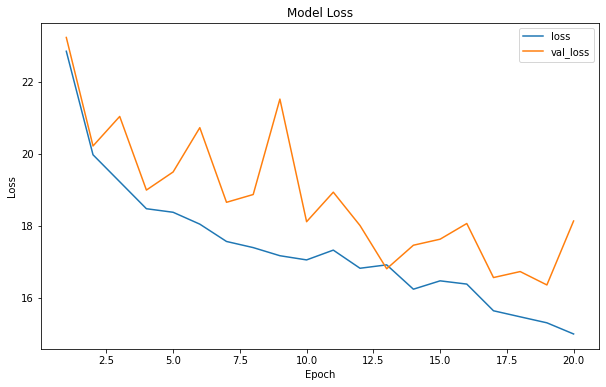

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(1,len(model.history.history['loss'])+1) ,model.history.history['loss'], label = 'loss') 
plt.plot(range(1,len(model.history.history['val_loss'])+1) ,model.history.history['val_loss'], label = 'val_loss') 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show();

In [ ]:
ls logs/000/

ep003-loss61.939-val_loss52.789.h5  ep019-loss16.239-val_loss17.461.h5
ep006-loss37.858-val_loss37.081.h5  ep022-loss15.640-val_loss16.563.h5
ep007-loss19.974-val_loss20.219.h5  events.out.tfevents.1638716834.8e85ffe35ed2
ep009-loss31.532-val_loss32.632.h5  events.out.tfevents.1638717268.8e85ffe35ed2
ep010-loss18.377-val_loss19.496.h5  trained_weights_final.h5
ep013-loss17.395-val_loss18.870.h5  trained_weights_stage_1.h5


In [ ]:
model.save('my_model')

### Clean Memory

### Restart Runtime Again: tl;dr: The GPU runs out of Memory and idk how to free it other than resetting the runtime

### Imports

In [ ]:
%tensorflow_version 1.x

In [ ]:
import h5py
print("h5py Version: ", h5py.__version__) # needs to be  2.10.0

h5py Version:  2.10.0


In [ ]:
import keras
print("Keras Version: ", keras.__version__) # needs to be 2.2.4

Keras Version:  2.2.4


In [ ]:
import sys
import os
import configparser
import io
from collections import defaultdict

In [ ]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
!rm -rf yolov3
!git clone https://github.com/awells-uva/yolov3.git

Cloning into 'yolov3'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 67 (delta 33), reused 49 (delta 18), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
#!python /content/yolov3/yolo_video.py --model="/content/logs/000/trained_weights_stage_1.h5" --classes="/content/DS6050/mask_detection.v5-test-v2.yolokeras/train/_classes.txt" --image


In [ ]:
import h5py
h5py.File('/content/logs/000/trained_weights_final.h5','r')  

<HDF5 file "trained_weights_final.h5" (mode r)>

In [ ]:
#!python /content/yolov3/yolo_video.py --model="/content/logs/000/trained_weights_stage_1.h5" --classes="/content/_classes.txt" --image --testdir='/content/DS6050/testimages/'
!python /content/yolov3/yolo_video.py --model="/content/logs/000/trained_weights_final.h5" --classes="/content/_classes.txt" --image --testdir='/content/DS6050/testimages/'

Using TensorFlow backend.
Image detection mode
 Ignoring remaining command line arguments: ./path2your_video,



2021-12-05 15:28:14.952626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-12-05 15:28:14.952942: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55775296ca00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-05 15:28:14.952975: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-05 15:28:14.954644: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-05 15:28:15.174583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 15:28:15.175240: I tensorflow/compiler/xla/service/service.cc:168] XLA service

In [ ]:
%ls logs/000

In [ ]:
from IPython.display import Image, display
for image in os.listdir('/content/DS6050/testimages/boundedImages/'):
  display(Image(os.path.join('/content/DS6050/testimages/boundedImages/', image)))

# Run Model on Unknown Data aka Demo

In [ ]:
from google.colab import files

In [46]:
def gen_bounding_box(uploaded):
  import os
  from io import BytesIO
  import sys
  from PIL import Image
  import matplotlib.pyplot as plt
  outdir = '/content/testimage/'
  import shutil
  if os.path.isdir(outdir):
    shutil.rmtree(outdir) 
  os.mkdir(outdir)
  im = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))
  plt.imshow(im)
  plt.show()
  imgName = list(uploaded.keys())[0].replace(" ", "_")
  im.save(os.path.join(outdir,imgName))
  os.system('{} /content/yolov3/yolo_video.py --model="/content/logs/000/trained_weights_final.h5" --classes="/content/_classes.txt" --image --testdir={} > /dev/null 2>&1'.format(sys.executable, outdir))
  from IPython.display import Image, display
  for image in os.listdir('{}boundedImages/'.format(outdir)):
    display(Image(os.path.join('{}boundedImages/'.format(outdir), image)))

Saving Screen Shot 2021-12-05 at 11.11.14 AM.png to Screen Shot 2021-12-05 at 11.11.14 AM (1).png


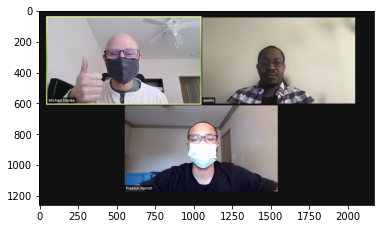

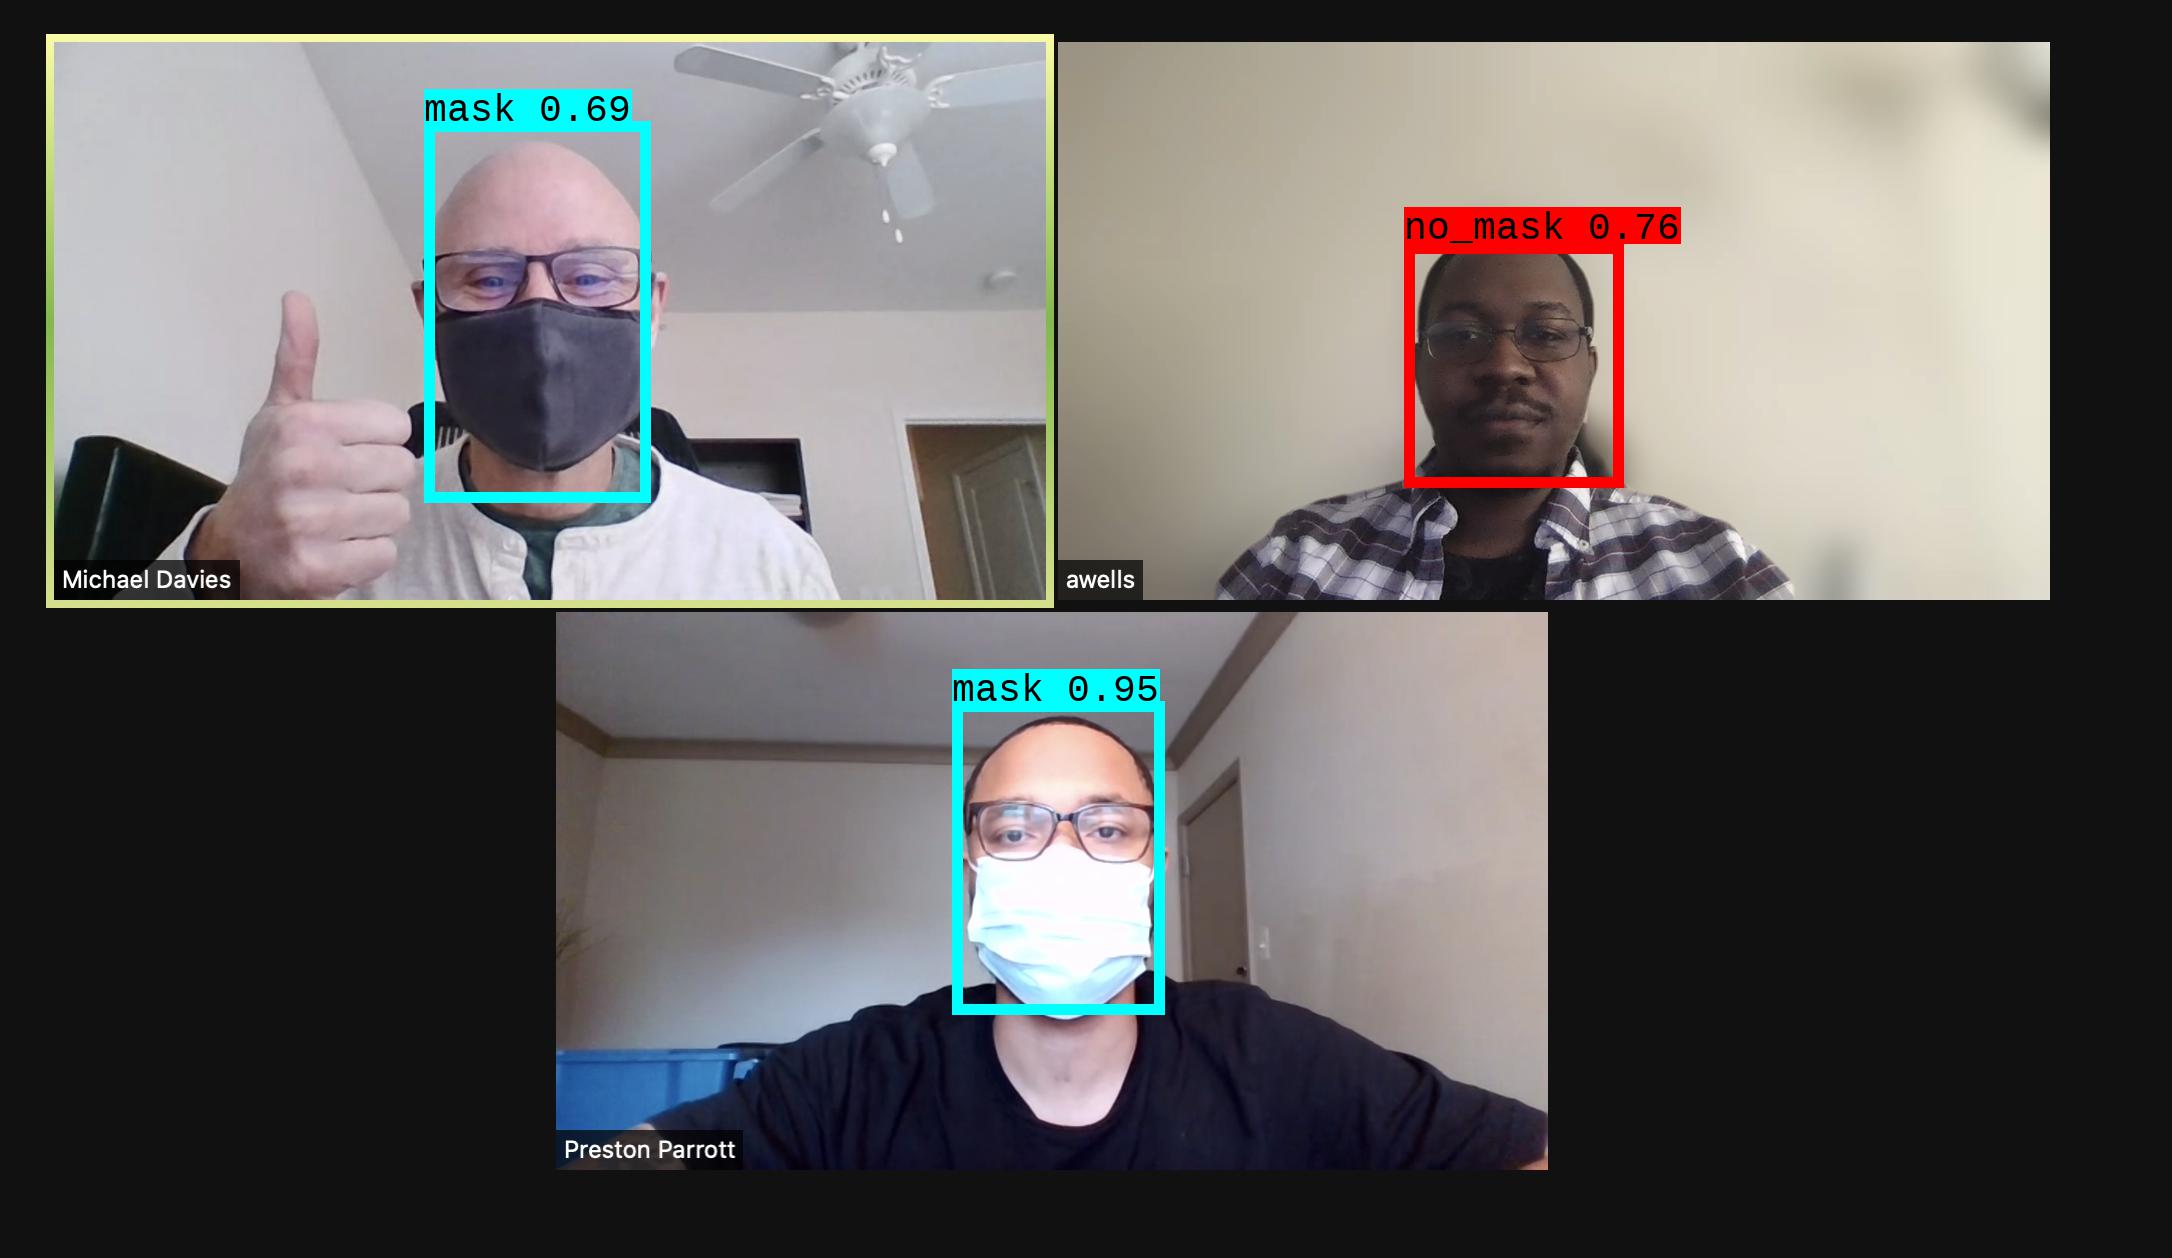

In [53]:
uploaded = files.upload()
gen_bounding_box(uploaded)